In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
%matplotlib inline

In [3]:
df = pd.read_csv('consumer_complaints.csv', low_memory=False)
df

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555952,07/01/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,Bank of America,NaN,NaN,NaN,NaN,Referral,07/07/2014,Closed with explanation,Yes,No,919529
555953,07/01/2014,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Residential Credit Solutions,NaN,NaN,"Older American, Servicemember",NaN,Referral,07/23/2014,Closed with explanation,No,No,918447
555954,07/10/2012,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,BB&T Financial,NaN,NaN,NaN,NaN,Phone,11/18/2013,Closed with explanation,Yes,No,114550
555955,04/14/2015,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,NaN,NaN,Global Recovery Group,NaN,NaN,NaN,NaN,Phone,04/14/2015,Untimely response,No,No,1329963


In [4]:
#Drop NaN values for states
df_clean_states = df[df['state'].notna()] 

In [6]:
#State with most disputes:
disputed_complaint = df[df['consumer_disputed?'] == 'Yes']
states = disputed_complaint['state']
states_clean = states.dropna().values
disp_states, counts = np.unique(states_clean, return_counts=True)
state = disp_states[np.argmax(counts)]
print("State is", state, "with disputes:", counts[np.argmax(counts)])

State is CA with disputes: 17615


<BarContainer object of 62 artists>

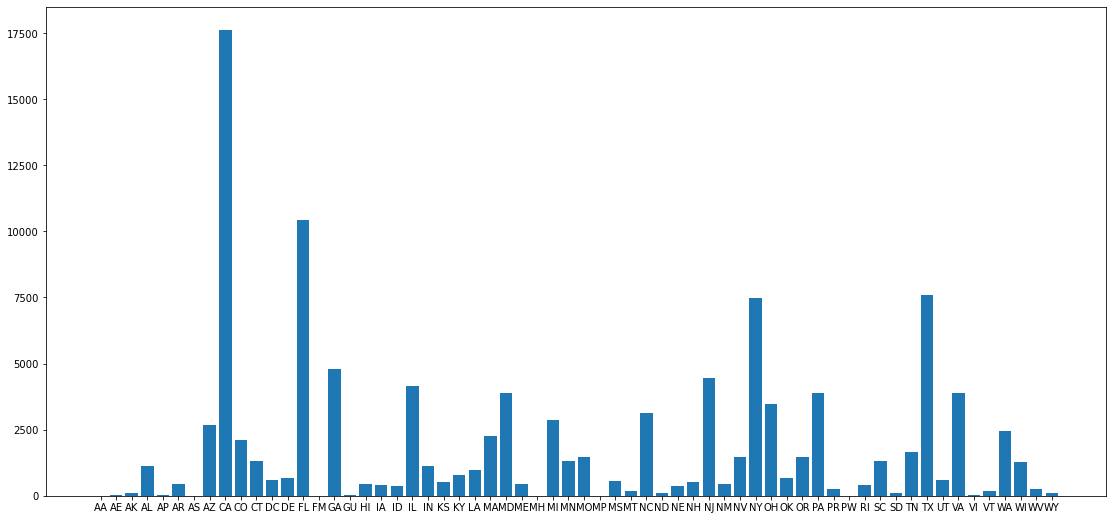

In [7]:
#Bar plot of states and dispute counts:
fig1, ax1 = plt.subplots(figsize=(19, 9))
ax1.bar(disp_states, counts, align='center')

In [8]:
#Getting count of issues per state with products
state_issue_count = df.groupby(['state', 'product', 'issue']).size().reset_index()
state_issue_count.columns = ['state', 'product', 'issue','count']
state_issue_count

,state,product,issue,count
0,AA,Bank account or service,"Account opening, closing, or management",1
1,AA,Credit card,Identity theft / Fraud / Embezzlement,1
2,AA,Credit card,Rewards,1
3,AA,Mortgage,"Loan modification,collection,foreclosure",2
4,AA,Mortgage,"Loan servicing, payments, escrow account",2
...,...,...,...,...
4651,WY,Student loan,Can't repay my loan,3
4652,WY,Student loan,Dealing with my lender or servicer,9
4653,WY,Student loan,Getting a loan,1
4654,WY,Student loan,Problems when you are unable to pay,1


In [9]:
#States with 5 highest dispute counts, issues and product
state_issue_count.sort_values(by = 'count', ascending = False).head()

,state,product,issue,count
501,CA,Mortgage,"Loan modification,collection,foreclosure",19433
942,FL,Mortgage,"Loan modification,collection,foreclosure",11337
502,CA,Mortgage,"Loan servicing, payments, escrow account",8957
4028,TX,Credit reporting,Incorrect information on credit report,8712
485,CA,Credit reporting,Incorrect information on credit report,8585


In [10]:
#States with 5 lowest dispute counts with related issues and products
state_issue_count.sort_values(by = 'count', ascending = False).tail()

,state,product,issue,count
3083,NV,Prepaid card,"Overdraft, savings or rewards features",1
347,AZ,Consumer Loan,Payment to acct not credited,1
344,AZ,Consumer Loan,Lender repossessed or sold the vehicle,1
1,AA,Credit card,Identity theft / Fraud / Embezzlement,1
0,AA,Bank account or service,"Account opening, closing, or management",1


In [21]:
#Highest issues per product
product_issue_count = df.groupby(['product', 'issue']).size().reset_index()
product_issue_count.columns = ['product', 'issue', 'count']
product_issue_count.sort_values(by = 'count', ascending=False).head()

,product,issue,count
75,Mortgage,"Loan modification,collection,foreclosure",97191
59,Credit reporting,Incorrect information on credit report,66718
76,Mortgage,"Loan servicing, payments, escrow account",60375
62,Debt collection,Cont'd attempts collect debt not owed,42285
0,Bank account or service,"Account opening, closing, or management",26661


Text(0, 0.5, 'Product')

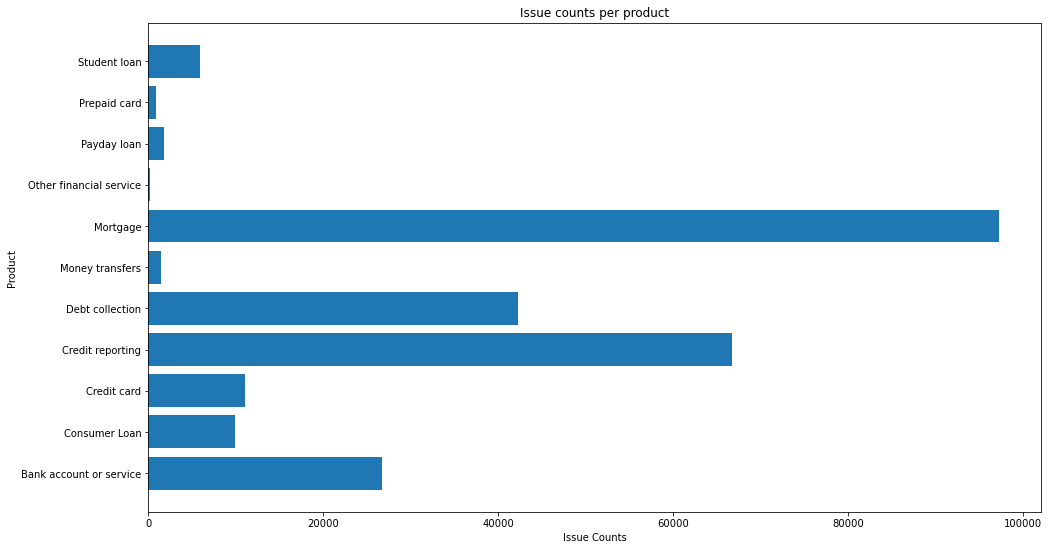

In [23]:
#BAR PLOT
fig2, ax2 = plt.subplots(figsize=(16, 9))
#prod_u, counts = np.unique(product_issue_count['product'].values, return_counts=True)
ax2.barh(product_issue_count['product'], product_issue_count['count'])
    
#ax2.set_title("Issue counts per product with (companies are bar colors)")
ax2.set_title("Issue counts per product")
ax2.set_xlabel('Issue Counts')
ax2.set_ylabel('Product')

In [24]:
#@TODO Banks' products with highest issues
bank_prod_count = df.groupby(['company', 'product', 'issue']).size().reset_index()
bank_prod_count

,company,product,issue,0
0,"(Former)Shapiro, Swertfeger & Hasty, LLP",Debt collection,Disclosure verification of debt,2
1,"(Former)Shapiro, Swertfeger & Hasty, LLP",Mortgage,"Loan modification,collection,foreclosure",1
2,"(Former)Shapiro, Swertfeger & Hasty, LLP",Mortgage,"Loan servicing, payments, escrow account",1
3,"1st 2nd Mortgage Company Of NJ, Inc.",Mortgage,"Application, originator, mortgage broker",1
4,1st Alliance Lending,Debt collection,Cont'd attempts collect debt not owed,1
...,...,...,...,...
18372,"iQuantified Management Services, LLC",Debt collection,Cont'd attempts collect debt not owed,1
18373,iServe Trust,Mortgage,Credit decision / Underwriting,1
18374,iServe Trust,Mortgage,"Loan modification,collection,foreclosure",4
18375,iServe Trust,Mortgage,"Loan servicing, payments, escrow account",1


In [134]:
#@TODO Common words in complaints

In [ ]:
#@TODO NLP prediction